# Pick out cues from Accelerometer data

Alternative alignment extraction path for multidevice accelerometry recordings. 

Some recordings include only one tapping or clapping cue, some include multiple.

For a single accelerometry recording:

    0. Load accelerometry file, resample and collapse to 1D absolut Jerk. 
    1. Load all relevant template cues and their approximate position.
    2. Automate IDing each synchronisation cue in the  with cross correlations.
    3. Review cue timing
    4. Save the detected timing of each cue IN DEVICE TIMESTAMP VALUES
    
Output timing information is used in a difference script to shift recordings to common concert time.

## libraries and function files

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

# Cue Templates
Pull in the one or many cue templates used to locate cue timing in the jerk data

This sequence constructs the cue from a sequence of peak timings (claps or taps)

In [53]:
synch_times = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.719+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:02.500+0000')}
c_types = {'RE_Synch':'taps',
               'RD_Reic': 'claps',
               'RD_Synch':'taps',
               'RD_Reic2':'claps',} 
cue_files ={'RE_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic': './Timing/RD_Reic1.csv',
               'RD_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic2':'./Timing/RD_Reic2.csv',} 

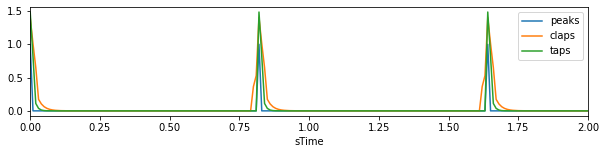

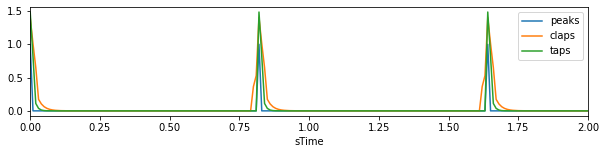

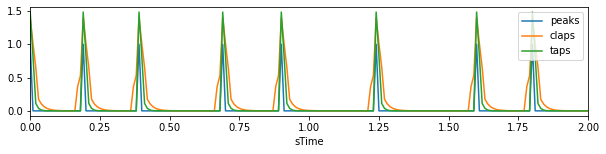

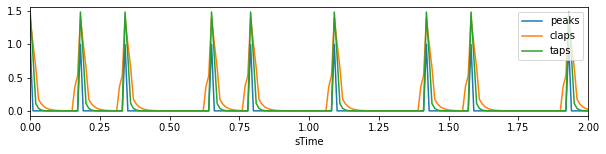

In [30]:
CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-10,20]
for c in synch_times.keys():
    cue_times = pd.read_csv(cue_files[c],",",header=None)
    if len(cue_times.columns)>3:
        cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
        cue_times['event'] = cue_times[1]
        cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
        peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
    else:
        peak_times = list(cue_times[0]-cue_times.loc[0,0])
    
    cue = al.cue_template_make(peak_times,sf,t_range)

    cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[10,2])
    plt.xlim([0,2])
    plt.show()
    CueT[c] = cue 

In [26]:
# Interval of time taken from signal to search for cue
cue

,sTime,peaks,taps,claps
0,-10.00,0,0.0,0.0
1,-9.99,0,0.0,0.0
2,-9.98,0,0.0,0.0
3,-9.97,0,0.0,0.0
4,-9.96,0,0.0,0.0
...,...,...,...,...
2995,19.95,0,0.0,0.0
2996,19.96,0,0.0,0.0
2997,19.97,0,0.0,0.0
2998,19.98,0,0.0,0.0


In [27]:
CueT.keys()

dict_keys(['RE_Synch', 'RD_Synch', 'RD_Reic', 'RD_Reic2'])

# Acc Data load
This notebook is initially build for processing Equivital data from the Bodies in Concert 

In [32]:
eq_data_loc = '../Data/Equivital/Lydo_Rehearsal/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)

In [33]:
pi = 0
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']
pid = player_order[pi]

In [34]:
cues_aligned = pd.DataFrame(columns = synch_times.keys())

## Set up Cue detection through a whole set
With mechanism to correct entries

Cycle from here

In [57]:
#pid = 'VN202'

In [261]:
pid= player_order[pi]

VN204


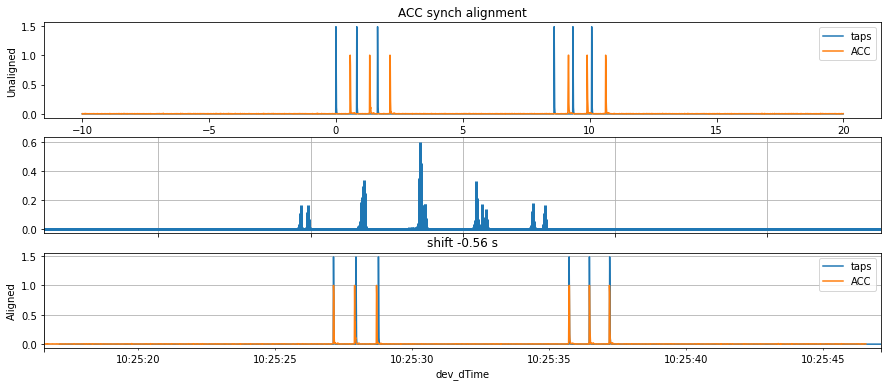

2023-02-15 10:25:27.133000+00:00


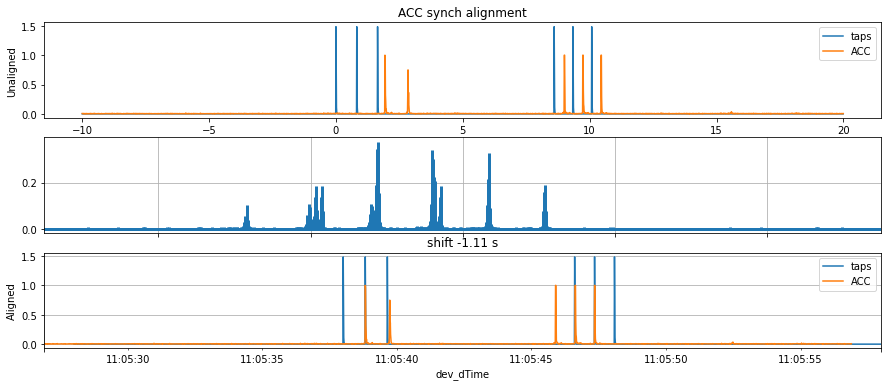

2023-02-15 11:05:38.007000+00:00


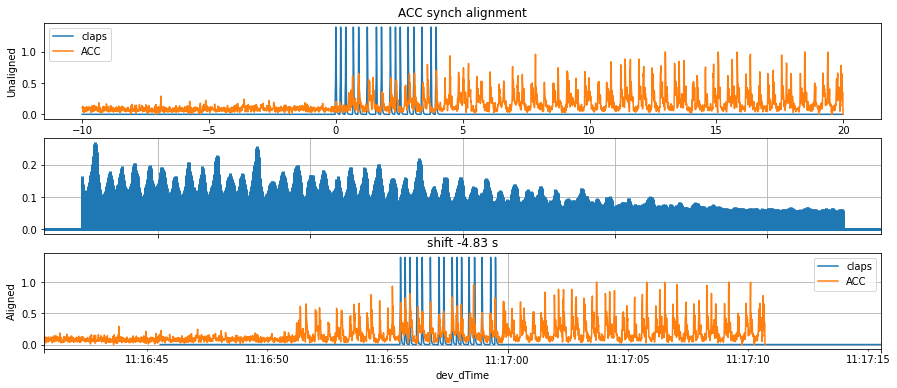

2023-02-15 11:16:55.549000+00:00


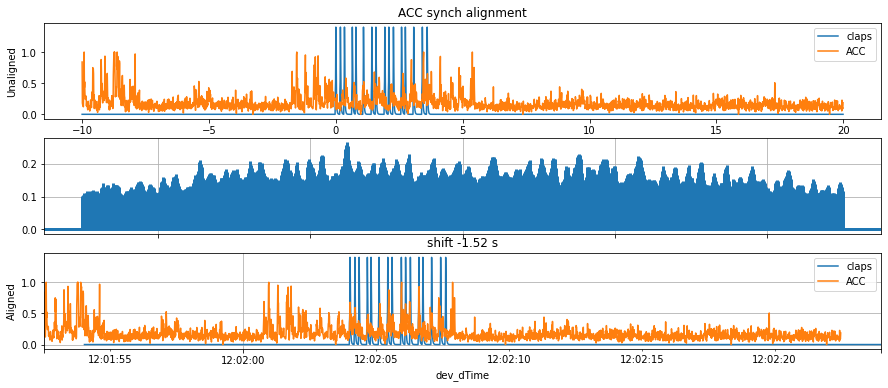

2023-02-15 12:02:04.020000+00:00


In [262]:
print(pid)
sigFileLoc = eq_data_loc + 'FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]
V = pd.read_csv(sigFileLoc,skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
Results = {}

for c in synch_times.keys():
    cue = CueT[c].copy()
    prelim_synch_time = synch_times[c]
    c_type = c_types[c] 

    Res = al.min_align(ACC,cue.loc[:,['sTime',c_type]],prelim_synch_time,5)
    Results[c] = Res
    cues_aligned.loc[pid,c] = Res['best']
    print(Res['best'])

Check individual alignments

In [235]:
c = 'RE_Synch'

In [263]:
c = 'RD_Synch'

In [266]:
c = 'RD_Reic' 

In [270]:
c = 'RD_Reic2'

In [202]:
cues_aligned.loc[pid,c] = np.datetime64('NaT')

RD_Reic2


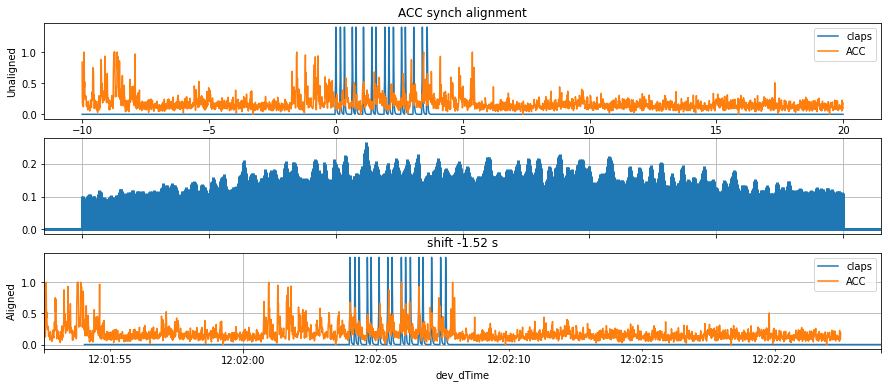

,ind,corr,shift s
0,255,0.211156,-3.45
1,321,0.206523,-2.79
2,334,0.204344,-2.66
3,336,0.203411,-2.64
4,367,0.214747,-2.33
5,369,0.212254,-2.31
6,382,0.204672,-2.18
7,398,0.214752,-2.02
8,415,0.225880,-1.85
9,448,0.265162,-1.52


In [271]:
print(c)
shift_limits = 3 # set the range of shifts (+/-) tests. It can be up to the length used to generate the results
Res = al.min_align(ACC,CueT[c].loc[:,['sTime',c_types[c]]],synch_times[c],6)

ccthresh = 0.2# set threshold below 
peaks = al.alt_xc_peaks(Res,ccthresh)
peaks

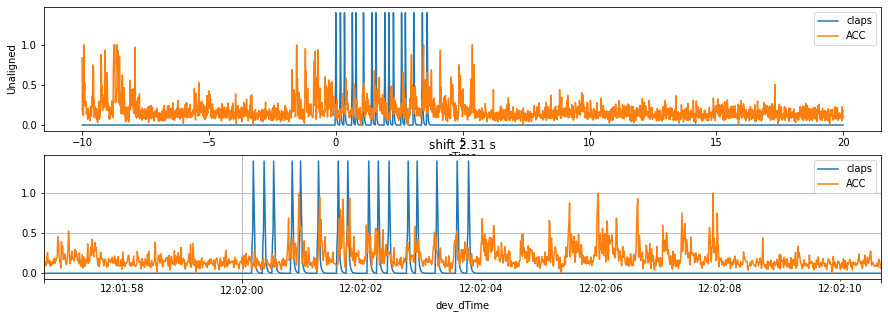

2023-02-15 12:02:00.190000+00:00


In [276]:
# specify the shift you want to check by peak or enter a shift offset in seconds in test_shift
pk_int =25
cues_aligned.loc[pid,c] = al.test_shift(Res,peaks.loc[pk_int,'shift s'])
print(cues_aligned.loc[pid,c])

In [ ]:
-01.65

In [ ]:
-2.42

In [277]:
cues_aligned.to_csv('RE_RD_Equivitals.csv')
cues_aligned

,RE_Synch,RD_Synch,RD_Reic,RD_Reic2
VN102,2023-02-15 10:25:26.493000+00:00,2023-02-15 11:05:36.497000+00:00,2023-02-15 11:16:50.469000+00:00,2023-02-15 12:01:59.190000+00:00
VN107,NaT,NaT,2023-02-15 11:16:53.069000+00:00,2023-02-15 12:02:01.800000+00:00
VN106,2023-02-15 10:25:27.483000+00:00,2023-02-15 11:05:37.647000+00:00,2023-02-15 11:16:51.639000+00:00,2023-02-15 12:02:00.560000+00:00
VN108,2023-02-15 10:25:27.473000+00:00,2023-02-15 11:05:37.597000+00:00,2023-02-15 11:16:51.689000+00:00,NaT
VN101,2023-02-15 10:25:25.863000+00:00,2023-02-15 11:05:35.837000+00:00,NaT,2023-02-15 12:01:58.590000+00:00
VN105,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.977000+00:00,2023-02-15 11:16:50.909000+00:00,2023-02-15 12:01:59.660000+00:00
VN103,2023-02-15 10:25:26.673000+00:00,2023-02-15 11:05:36.677000+00:00,2023-02-15 11:16:52.809000+00:00,2023-02-15 12:01:59.520000+00:00
VN104,2023-02-15 10:25:26.873000+00:00,2023-02-15 11:05:36.917000+00:00,2023-02-15 11:16:50.919000+00:00,2023-02-15 12:01:59.660000+00:00
VN205,2023-02-15 10:25:27.193000+00:00,2023-02-15 11:05:37.337000+00:00,2023-02-15 11:16:51.349000+00:00,2023-02-15 12:02:00.250000+00:00
VN203,2023-02-15 10:25:27.143000+00:00,2023-02-15 11:05:37.367000+00:00,2023-02-15 11:16:51.379000+00:00,2023-02-15 12:02:00.270000+00:00


In [278]:
pi+=1

In [140]:
pid

'VN104'

# device time variance

In [1035]:
print((cues_aligned['C1_Reic'] - cues_aligned['C1_Synch']).dt.total_seconds().mean())
print((cues_aligned['C1_Reic'] - cues_aligned['C1_Synch']).dt.total_seconds().std())

723.8497272727271
0.05762200953704032


In [1036]:
print((cues_aligned['C2_Reic'] - cues_aligned['C2_Synch']).dt.total_seconds().mean())
print((cues_aligned['C2_Reic'] - cues_aligned['C2_Synch']).dt.total_seconds().std())

648.1864150943397
0.0562649754295462


In [1039]:
print((cues_aligned['C2_Reic'] - cues_aligned['C1_Reic']).dt.total_seconds().mean())
print((cues_aligned['C2_Reic'] - cues_aligned['C1_Reic']).dt.total_seconds().std())

6107.947346153848
0.15852294750875173


In [1037]:
(cues_aligned['C2_Reic'] - cues_aligned['C2_Synch']).dt.total_seconds()

VN102    648.15
VN107       NaN
VN106    648.16
VN108    648.15
VN101    648.01
VN105    648.17
VN104    648.21
VN103    648.21
VN205    648.18
VN203    648.16
VN202    648.29
VN206    648.12
VN209    648.19
VN210    648.20
VN207    648.22
VN208    648.23
VN201    648.26
VN204    648.19
VA305    648.10
VA307    648.21
VA308    648.13
VA301    648.12
VA306    648.34
VA302    648.23
VA303    648.22
VA304    648.19
LS406    648.20
LS407    648.20
LS408    648.17
LS405    648.24
LS401    648.15
LS403    648.22
LS402    648.20
LS410    648.16
LS404    648.13
WW505    648.13
WW502    648.29
WW503    648.22
WW506    648.13
WW501    648.07
WW504    648.23
WW507    648.24
BR604    648.12
BR603    648.13
BR606    648.22
BR607    648.19
BR605    648.22
BR601    648.15
PC704    648.23
PC705    648.18
PC703    648.21
PC701    648.21
PC702    648.22
PC707    648.18
dtype: float64

In [1038]:
(cues_aligned['C2_Reic'] - cues_aligned['C1_Reic']).dt.total_seconds()

VN102    6107.771
VN107    6107.951
VN106    6108.001
VN108    6107.981
VN101    6107.641
VN105    6107.711
VN104    6107.691
VN103    6107.721
VN205    6107.961
VN203    6108.041
VN202    6108.371
VN206    6107.911
VN209         NaN
VN210    6107.991
VN207    6108.001
VN208    6107.971
VN201    6108.061
VN204    6107.981
VA305    6107.951
VA307    6108.001
VA308    6108.001
VA301    6107.941
VA306    6107.691
VA302    6107.951
VA303    6108.021
VA304    6108.001
LS406    6108.001
LS407    6108.041
LS408    6108.021
LS405    6107.971
LS401    6107.991
LS403    6107.941
LS402    6108.011
LS410    6107.961
LS404    6107.921
WW505    6107.991
WW502    6107.971
WW503         NaN
WW506    6107.951
WW501    6107.961
WW504    6107.171
WW507    6108.001
BR604    6107.981
BR603    6108.041
BR606    6107.951
BR607    6107.971
BR605    6107.961
BR601    6108.021
PC704    6108.091
PC705    6107.971
PC703    6107.991
PC701    6107.981
PC702    6108.051
PC707    6108.031
dtype: float64